In [1]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import string
from pprint import pprint

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
base_url = 'https://www.rottentomatoes.com/m/'
# add the correct User-Agent
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

In [22]:
def get_url(base_url, movie_name):
    # remove punctuation from movie name if it has
    if('â' in movie_name):
        movie_name = movie_name.replace('â', '')
    
    title = ''.join(item for item in movie_name if item not in string.punctuation or item == '-')
                
    tag_list = title.lower().split()
    
    tag = ''
    
    for item in tag_list:
        if(item == 'ep'):
            item = 'episode'
        
        if('-' in item):
            item = item.replace('-', '_')
        
        if(item != tag_list[-1]):
            tag = tag + str(item) + '_'
        else:
            tag = tag + str(item)
    
    url = base_url + tag
    
    return url

In [5]:
get_url(base_url, 'The Twilight Saga: Breaking Dawn, Part 2')

'https://www.rottentomatoes.com/m/twilight_saga_breaking_dawn_part_2'

In [6]:
movie_data = pd.read_csv('../movie_base.csv')
movie_data.head()

,Unnamed: 0,Rank,Released,Movie,DomesticBox Office,InternationalBox Office,WorldwideBox Office
0,0,1,2015,Star Wars Ep. VII: The Force Awakens,936662225,1116648,2053311
1,1,2,2009,Avatar,760507625,2015837,2776345
2,2,3,2018,Black Panther,700059566,648300000,1348359
3,3,4,2018,Avengers: Infinity War,678815482,1369988,2048803
4,4,5,1997,Titanic,659363944,1548844,2208208


In [7]:
# get url list waiting to crawl
tomato_movie_data = {
    'url': []
}

for movie in movie_data.Movie:
    tomato_movie_data['url'].append(get_url(base_url, movie))

In [8]:
# check if url is valide in rotten tomato
def get_html(url):
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status
        #site encoding
        r.encoding = 'utf-8'
        return r.text
    except:
        print('ERROR')
        pass

In [9]:
def get_content(url):
    html = get_html(url)
    soup = bs(html, 'lxml')
    data = {}
    try:
        try:
            data['cretic(%)'] = soup.find('span', class_='superPageFontColor').span.text
        except:
            data['cretic(%)'] = 'na'
            
        try:
            data['cretic_rate'] = soup.find('div', id='scoreStats').findChildren()[0].text[25:].strip()
        except:
            data['cretic_rate'] = 'na'
            
        try:
            data['cretic_count'] = soup.find('div', id='scoreStats').findChildren()[2].text[18:].strip()
        except:
            data['cretic_count'] = 'na'
            
        try:
            data['cretic_fresh'] = soup.find('div', id='scoreStats').findChildren()[7].text
        except:
            data['cretic_fresh'] = 'na'
        
        try:
            data['cretic_rot'] = soup.find('div', id='scoreStats').findChildren()[10].text
        except:
            data['cretic_rot'] = 'na'
            
        try:
            data['user(%)'] = soup.find('div', class_='audience-score').find('span', class_='superPageFontColor').text[:2]
        except:
            data['user(%)'] = 'na'
            
        try:
            data['user_rate'] = soup.find('div', class_='audience-info').findChildren()[0].contents[2].strip()
        except:
            data['user_rate'] = 'na'
        
        try:
            data['user_number'] = soup.find('div', class_='audience-info').findChildren()[2].contents[2].strip()
        except:
            data['user_number'] = 'na'

    except:
        print('error')
    
    return data

In [26]:
movie_crawl_list = []
for url in tomato_movie_data['url']:
    data = get_content(url)
    movie_crawl_list.append(data)

In [27]:
tomato_data = pd.DataFrame(data=movie_crawl_list,
                           columns=["cretic(%)", "cretic_count", 'cretic_fresh', 'cretic_rate', 'cretic_rot',
                                   'user(%)', 'user_number', 'user_rate'])
tomato_data['name'] = movie_data['Movie']
tomato_data['url'] = tomato_movie_data['url']

In [30]:
# export final file
tomato_data.to_csv('tomato_final.csv', encoding='utf-8')

In [37]:
#tomato_list_clean = tomato_data.loc[tomato_data['cretic(%)'] != 'na']
#tomato_list_clean.to_csv('tomato.csv')
tomato_list_clean = pd.read_excel('tomato_final_version_2.')
tomato_list_clean

XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'cretic(%'

In [21]:
tomato_data.loc[tomato_data['cretic(%)'] == 'na'][['name', 'url']]

,name,url
2,Black Panther,https://www.rottentomatoes.com/m/black_panther
7,Star Wars Ep. VIII: The Last Jedi,https://www.rottentomatoes.com/m/star_wars_epi...
9,The Dark Knight,https://www.rottentomatoes.com/m/dark_knight
11,Beauty and the Beast,https://www.rottentomatoes.com/m/beauty_and_th...
14,Star Wars Ep. IV: A New Hope,https://www.rottentomatoes.com/m/star_wars_epi...
16,The Dark Knight Rises,https://www.rottentomatoes.com/m/dark_knight_r...
18,ET: The Extra-Terrestrial,https://www.rottentomatoes.com/m/et_the_extra_...
19,The Hunger Games: Catching Fire,https://www.rottentomatoes.com/m/hunger_games_...
29,Spider-Man,https://www.rottentomatoes.com/m/spider_man_
38,Beauty and the Beast,https://www.rottentomatoes.com/m/beauty_and_th...


In [51]:
tomato_data.loc[tomato_data['name'] == 'Harry Potter and the Half-Blood Prince'].url

77    https://www.rottentomatoes.com/m/harry_potter_...
Name: url, dtype: object

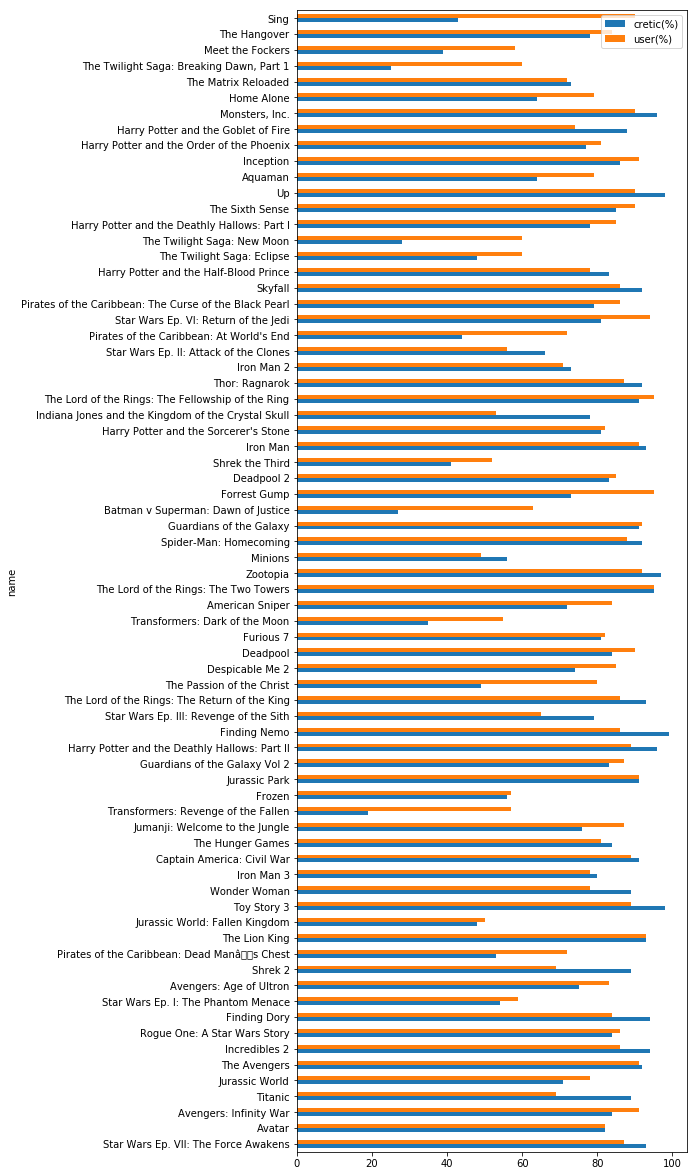

In [52]:
tomato_plot = pd.read_csv('tomato.csv').set_index('name')
tomato_fresh = tomato_plot[['cretic(%)', 'user(%)']].plot(kind='barh', figsize=(7, 21))